# Abstract

This notebook evaluates our best bidding strategy. This strategy is consisted of an ensemble model for pCTR and a linear formula. We also tune the constant C, for multiplying base_bid. This startegy manages an impressive __165 clicks__ of total 202 clicks in the validation set (81.6%). The most impressive characteristic of this strategy though, is that it achieves a very high __CTR__ that ranges from __0.21__ to __0.34%__, while clicks fall down to no less than 141. Depending on the advertiser (whether he wants to bid agreesively or conservatively), this very high CTR enables him to use this strategy accordingly. 

# Import data

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

In [2]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [3]:
print(train.shape, validation.shape)

(2430981, 25) (303925, 25)


# Import Predictions

In [4]:
lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
xgb_preds = pd.read_csv("Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")
dwane_preds = pd.read_csv("Prediction_csv/click_predictions_narrow.csv")
#lasso_preds = pd.read_csv("Prediction_csv/lasso_basebid.csv", index_col  = "Unnamed: 0")

In [5]:
# Ensemble model
ensemble_prob =xgb_preds["click_proba"]*dwane_preds["click_proba"]
ensemble_pCTR_preds = pd.DataFrame(columns = ["bidid", "click_proba"], 
                                   data = list(zip(validation["bidid"], ensemble_prob)))

In [6]:
ensemble_pCTR_preds.head()

,bidid,click_proba
0,bbcb813b6166538503d8b33a5602d7d72f6019dc,0.0
1,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,0.0
2,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,0.0
3,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,0.0
4,0899bf144249458ea9c89188473694bf44c7ca15,0.0


In [7]:
base_bid = train.loc[ train["click"] == 1, "payprice"].mean()
avgCTR = train["click"].sum()*100/train.shape[0]

In [8]:
print("Base bid: {}, avgCTR: {}, ratio: {}".format(base_bid, avgCTR, base_bid/avgCTR))

Base bid: 105.46402677077523, avgCTR: 0.07375623256619447, ratio: 1429.899862037066


# Strategies

In [9]:
def Strategy1(sub_pCTR, c):
    
    avgCTR = sub_pCTR["click_proba"].mean()
    base_bid = train.loc[ train["click"] == 1, "payprice"].mean()
    bidprice = c*(sub_pCTR["click_proba"] * base_bid) / avgCTR
    return bidprice

In [10]:
# Values to try for the constant value in Linear strategy
c = np.linspace(0.5,7, 30)
c

array([0.5       , 0.72413793, 0.94827586, 1.17241379, 1.39655172,
       1.62068966, 1.84482759, 2.06896552, 2.29310345, 2.51724138,
       2.74137931, 2.96551724, 3.18965517, 3.4137931 , 3.63793103,
       3.86206897, 4.0862069 , 4.31034483, 4.53448276, 4.75862069,
       4.98275862, 5.20689655, 5.43103448, 5.65517241, 5.87931034,
       6.10344828, 6.32758621, 6.55172414, 6.77586207, 7.        ])

# Evaluate Results

In [13]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, c):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["bidprice_predicted"] = Strategy1(submission_pCTR, c)
    
    return validation_check


def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                if (balance > row[1]["bidprice_predicted"]):
                    
                    impressions+=1
                    clicks+=row[1]["click"]
                    cost+=row[1]["payprice"]
                    balance-=row[1]["payprice"]
                else:
                    pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/impressions
    cpc = cost/clicks/1000
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, cost,\
                                                                                                                     ctr, cpm, cpc))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [14]:
results = pd.DataFrame(columns = ["pCTR_model", "constant", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
k=0

start = time.time()

for constant in c:
        
        # Strategy 1
        validation_check = ValidationDataFrame(ensemble_pCTR_preds, constant)
        print("\033[1m Constant: {} \033[0m ".format(constant))
        impressions, clicks, cost, auctions_participated, ctr, cpm, cpc = ValidateStrategy(validation_check)
        results.loc[k] = ["Ensmble", constant, impressions, clicks, cost, ctr, cpm, cpc]
        k+=1 
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

 Constant: 0.5  
Strategy statistics:
Auctions participated: 303925 | Impressions: 41405 | Clicks: 142 | Cost: 2840634 | CTR: 0.34295374954715613 | CPM: 68.60606206979833 | CPC: 20.004464788732395


 Constant: 0.7241379310344828  
Strategy statistics:
Auctions participated: 303925 | Impressions: 48045 | Clicks: 144 | Cost: 3426873 | CTR: 0.29971901342491414 | CPM: 71.32631907586638 | CPC: 23.797729166666667


 Constant: 0.9482758620689655  
Strategy statistics:
Auctions participated: 303925 | Impressions: 52732 | Clicks: 151 | Cost: 3862518 | CTR: 0.2863536372601077 | CPM: 73.24808465447926 | CPC: 25.57958940397351


 Constant: 1.1724137931034484  
Strategy statistics:
Auctions participated: 303925 | Impressions: 56303 | Clicks: 151 | Cost: 4193139 | CTR: 0.26819174821945546 | CPM: 74.47452178391916 | CPC: 27.769132450331128


 Constant: 1.396551724137931  
Strategy statistics:
Auctions participated: 303925 | Impressions: 59249 | Clicks: 152 | Cost: 4469952 | CTR: 0.2565444142517173 | 

In [15]:
#results["CPM"] = results["CPM"]/1000
# results["CPC"] = results["CPC"]/1000

In [16]:
results.to_csv("ValidationSet_Evaluation_Results_Tune_Ensemble.csv")

In [17]:
pd.options.display.max_rows = results.shape[0]
results.sort_values(by = ["Clicks", "CTR"], ascending = False)

,pCTR_model,constant,Impressions,Clicks,Cost,CTR,CPM,CPC
18,Ensmble,4.534483,76145,165,6149253,0.216692,80.757148,37.268200
19,Ensmble,4.758621,76696,165,6207997,0.215135,80.942904,37.624224
17,Ensmble,4.310345,75579,164,6084027,0.216991,80.498908,37.097726
20,Ensmble,4.982759,77049,164,6249974,0.212852,81.116874,38.109598
16,Ensmble,4.086207,74959,163,6017493,0.217452,80.277125,36.917135
21,Ensmble,5.206897,76869,163,6249989,0.212049,81.307016,38.343491
12,Ensmble,3.189655,71800,162,5687181,0.225627,79.208649,35.106056
13,Ensmble,3.413793,72698,162,5779417,0.222840,79.498982,35.675414
14,Ensmble,3.637931,73512,162,5864477,0.220372,79.775778,36.200475
15,Ensmble,3.862069,74234,162,5941742,0.218229,80.040709,36.677420


In [18]:
pd.options.display.max_rows = 60

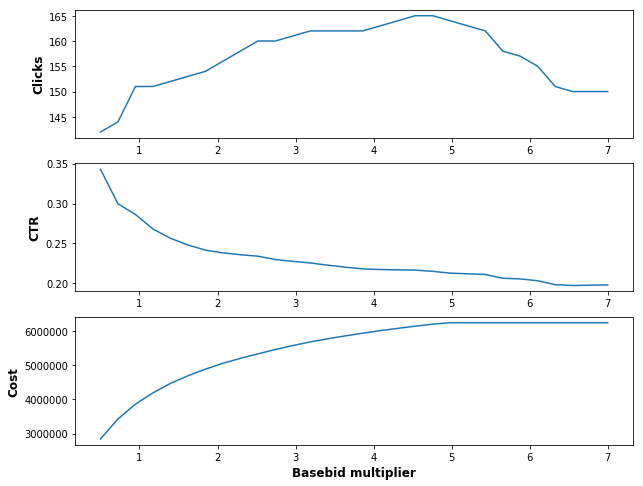

In [23]:
plt.figure(figsize = (10,8))

plt.subplot(3,1,1)
plt.plot(c, results["Clicks"])
plt.ylabel("Clicks", fontsize = 12, fontweight="bold")

plt.subplot(3,1,2)
plt.plot(c, results["CTR"])
plt.ylabel("CTR", fontsize = 12, fontweight="bold")

plt.subplot(3,1,3)
plt.plot(c, results["Cost"])
plt.ylabel("Cost", fontsize = 12, fontweight="bold")
plt.xlabel("Basebid multiplier", fontsize = 12, fontweight="bold")


plt.savefig("/project/Figures/group444.png")